# Evaluating Significance of Classifier Performance by Simulating Performance Distributions for Trivial Classifiers

In [1]:
from criticism import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression; 
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split 

%matplotlib inline

We will begin by instantiating a dataset $\mathcal{D} = (\mathbf x_i, y_i)_{i=1}^{N}$ consisting of feature vectors $\mathbf x_i$ and target labels $y_i$. We also split these into training and test sets.

In [2]:
N = 100
X, y = make_classification(n_samples=N)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

We now train a logistic regression classifier on these data and obtain a set of test set predictions. 

In [3]:
lrc = LogisticRegression(solver='lbfgs')
lrc.fit(Xtrain, ytrain)
ypred = lrc.predict(Xtest)

print('Simple Classification Report')
print('    Accuracy: %0.3f' %skm.accuracy_score(ytest, ypred))
print('    F1-Score: %0.3f' %skm.f1_score(ytest, ypred))
print('       Kappa: %0.3f' %skm.cohen_kappa_score(ytest, ypred))
print('         MCC: %0.3f' %skm.matthews_corrcoef(ytest, ypred))
print('         PPV: %0.3f' %metrics.ppv_score(ytest, ypred))
print('         NPV: %0.3f' %metrics.npv_score(ytest, ypred))
print(' Sensitivity: %0.3f' %metrics.sensitivity_score(ytest, ypred))
print(' Specificity: %0.3f' %metrics.specificity_score(ytest, ypred))

Simple Classification Report
    Accuracy: 0.960
    F1-Score: 0.966
       Kappa: 0.918
         MCC: 0.921
         PPV: 1.000
         NPV: 0.909
 Sensitivity: 0.933
 Specificity: 1.000


...but are these results meaningful or (dare I say) significant?

Deriving (accurate) standard errors and null distributions for these statistics can be difficult, so another approach is to simulate the performance of trivial classifiers and determine where the observed result lies in relation to this "simulated null" distribution. In this notebook, we will walk the reader through our approach to this method.

## Simulation of Trivial Classifier Performance

The central element in evaluation of classifier performance is the contingency table: 

| Confusion Mtx | $\hat{y}=1$            | $\hat{y}=0$        |
|---------------|------------------------|--------------------|
| $y=1$         | $\alpha \beta $        | $\alpha (1-\beta)$ |
| $y=0$         | $(1-\alpha)(1-\gamma)$ | $(1-\alpha)\gamma$ |

where $\alpha$ is the proportion of the test sample where $y=1$, $\beta$ is the classifier's sensitivity (the probability that when $y=1$ that the classifier will agree with the true label, and $\gamma$ is the classifier's specificity (the probability that when $y=0$ the classifier will agree with the true label). 

Thus, we have the following relationships 

- p(True Positive) = $P_{TP} = \alpha \beta$
- p(False Negative) = $P_{FN}=\alpha (1-\beta)$
- p(True Negative) = $P_{TN}=(1-\alpha) \gamma$
- p(False Positive) = $P_{FP}=(1-\alpha)(1-\gamma)$

from which we can compute a number of classification metrics. These are as follows: 

- $Accuracy(\alpha, \beta, \gamma) = P_{TP} + P_{TN}$
- $PPV(\alpha, \beta, \gamma) = \frac{P_{TP}}{P_{TP} + P_{FP}}$
- $NPV(\alpha, \beta, \gamma) = \frac{P_{TN}}{P_{TN} + P_{FN}}$
- $F_1(\alpha, \beta, \gamma) = 2\frac{PPV(\alpha, \beta, \gamma) \beta}{PPV(\alpha, \beta, \gamma) + \beta}$

We can also compute Cohen's Kappa by first calculating the chance agreement probability:
- $PChance(\alpha, \beta, \gamma) = (P_{TP}+ P_{FP})(P_{TP}+ P_{FN}) + (P_{TN}+ P_{FP})(P_{TN}+ P_{FN})$
- $Kappa(\alpha, \beta, \gamma) = \frac{Accuracy(\alpha, \beta, \gamma) - PChance(\alpha, \beta, \gamma)}{1-PChance(\alpha, \beta, \gamma)}$

The Matthews Correlation Coefficient (MCC) can also be easily computed: 
- $MCC(\alpha, \beta, \gamma) = \frac{P_{TP}P_{TN} - P_{FP}P_{FN}}{\sqrt{(P_{TP}+ P_{FP})(P_{TP}+ P_{FN})(P_{TN}+ P_{FP})(P_{TN}+ P_{FN})}}$

### Simulation Steps 

Given a dataset with $N$ samples of data $\mathcal{D} = (\mathbf x_i, y_i)_{i=1}^{N}$, we can compute the baseline probability of the positive class as 

$$
\alpha = \frac{1}{N} \sum_{i=1}^N \mathbb{I}[y_i = 1],
$$

where $\mathbb I[\cdot]$ is an indicator function that evaluates to 1 if the argument is true. Given only $\alpha$ and the number of subjects in the test set, and recalling that the parameters of a beta distribution are "pseudocounts," we can specify prior distributions on the sensitivity and specificity of a trivial classifier for data with the given sample size: 

\begin{aligned}
    \beta & \sim \mathrm{Beta}(\frac{1}{2}\alpha N, \frac{1}{2}(1-\alpha) N) \\
    \gamma & \sim \mathrm{Beta}(\frac{1}{2}(1-\alpha) N, \frac{1}{2} \alpha N)
\end{aligned}

which is to say that the expected true positive rate is 1/2 of the baseline positive rate (the other half will be false positives), and the true negative rate will be 1/2 of the baseline negative class rate (the other half will be false negatives).

We can then drawn $M$ samples from these distributions (in the `criticism` package the default number of samples is set to 10,000), and compute distributions of the respective statistics.

## Evaluating the Classifier's Performance

Before we look further under the hood, let's evaluate our classifier's performance. 

We begin by instantiating the `SimulationScorer` object for the various scoring statistics available. 

In [4]:
print('Available Scoring Metrics for Simulation-Based Criticism')
for s in metrics.metricdict.keys():
    print('\t%s' %s)

Available Scoring Metrics for Simulation-Based Criticism
	accuracy
	f1_score
	cohen_kappa_score
	matthews_corrcoef
	sensitivity
	specificity
	ppv
	npv


In [5]:
scorers = [SimulationScorer(metric, nsamples=10000) for metric in metrics.metricdict.keys()]

We can then compute the simulation-based comparisions: 

In [6]:
scores = np.stack([Scorer(ytest, ypred) for Scorer in scorers])
scores

array([[9.60000000e-01, 0.00000000e+00],
       [9.65517241e-01, 0.00000000e+00],
       [9.18032787e-01, 0.00000000e+00],
       [9.21132373e-01, 0.00000000e+00],
       [9.33333333e-01, 7.00000000e-04],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [9.09090909e-01, 1.00000000e-04]])

We can concatenate the summary reports from each scorer, too, just to make things look nicer.

In [7]:
results = pd.concat([Scorer.summary() for Scorer in scorers], ignore_index=False)
results

,Value,P(t>Value),Null Median,Null CrI,N,P(y=1),NSamples
Accuracy,0.960000,0.0000,0.521941,"(0.327, 0.7)",25,0.6,10000
F1,0.965517,0.0000,0.605002,"(0.381, 0.767)",25,0.6,10000
Kappa,0.918033,0.0000,-0.001249,"(-0.363, 0.369)",25,0.6,10000
MCC,0.921132,0.0000,0.002863,"(-0.37, 0.376)",25,0.6,10000
Sensitivity,0.933333,0.0007,0.608434,"(0.332, 0.843)",25,0.6,10000
Specificity,1.000000,0.0000,0.392964,"(0.159, 0.67)",25,0.6,10000
PPV,1.000000,0.0000,0.600519,"(0.429, 0.75)",25,0.6,10000
NPV,0.909091,0.0001,0.398891,"(0.184, 0.656)",25,0.6,10000


In the above table, $P(t>Value)$ is the proportion of all samples from the $M=NSamples$ draws from the simulation that exceeded the true value observed in the data (denoted "Value"). The "Null Median" column refers to the median of the samples from the trivial classifier's "Null" distribution. The "Null CrI" is the 95% *credible* interval for the samples from the simulated Null distribution. The $N$ column is the size of the testing set, and $P(y=1)$ is the probability of the positive class at baseline in the test set. We can see that our classifier generally does better than would be expected by chance alone. However, let's make some plots to show this a bit more.

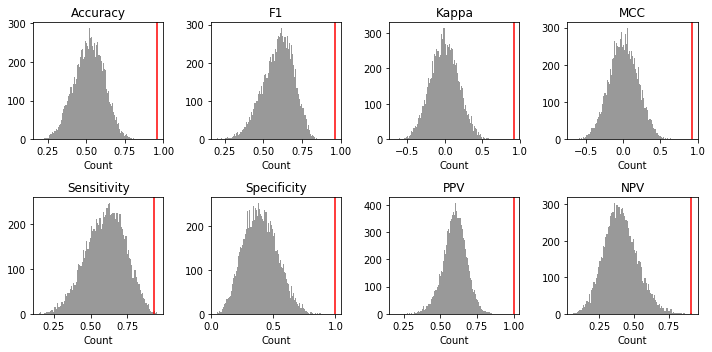

In [17]:
indices = np.stack(np.array_split(np.arange(8), 2))
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
for i in range(8):
    i_, j_ = np.argwhere(np.equal(indices, i))[0]
    ax[i_, j_].set_title(scorers[i].stat_name)
    ax[i_, j_].set_xlabel('Statistic Value')
    ax[i_, j_].set_xlabel('Count')
    ax[i_, j_].hist(scorers[i].null_samples_, bins=100, alpha=0.4, facecolor='k')
    ax[i_, j_].axvline(x=scorers[i].score_, c='r')
plt.tight_layout()